In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

try:
    df_public = pd.read_csv('Mall_Customers.csv')
except FileNotFoundError:
    print("Mall_Customers.csv not found. Please download it from a public dataset source (e.g., Kaggle) and place it in the working directory.")
    # For demonstration, if the file is not found, we create a minimal mimic of the dataset.
    df_public = pd.DataFrame({
        'CustomerID': np.arange(1, 201),
        'Genre': np.random.choice(['Male', 'Female'], 200),
        'Age': np.random.randint(18, 70, 200),
        'Annual Income (k$)': np.random.randint(15, 140, 200),
        'Spending Score (1-100)': np.random.randint(1, 101, 200)
    })


In [2]:

# Display a preview and summary of the public dataset
print("=== Public Dataset Preview ===")
print(df_public.head())
print("\n=== Summary Statistics ===")
print(df_public.describe())
print("\n=== Missing Values per Column ===")
print(df_public.isnull().sum())


=== Public Dataset Preview ===
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

=== Summary Statistics ===
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.0000

In [4]:

# -----------------------------------------
# 2. Generate Synthetic Data from Public Dataset
# -----------------------------------------
# Instead of generating completely random synthetic data, we use bootstrapping with noise addition.
# This method samples from the public dataset (thus preserving its distribution) and adds a small Gaussian noise.
# This showcases the ability to augment real-world data.
n_synthetic = 500  # number of synthetic samples to generate

# For numeric features (Age, Annual Income, Spending Score):
# Sample with replacement and then add noise.
synthetic_age = df_public['Age'].sample(n=n_synthetic, replace=True).values
synthetic_income = df_public['Annual Income (k$)'].sample(n=n_synthetic, replace=True).values
synthetic_spending = df_public['Spending Score (1-100)'].sample(n=n_synthetic, replace=True).values

# Define a noise factor as a fraction of the original standard deviation (5% here)
noise_factor = 0.05
synthetic_age = synthetic_age + np.random.normal(0, noise_factor * df_public['Age'].std(), n_synthetic)
synthetic_income = synthetic_income + np.random.normal(0, noise_factor * df_public['Annual Income (k$)'].std(), n_synthetic)
synthetic_spending = synthetic_spending + np.random.normal(0, noise_factor * df_public['Spending Score (1-100)'].std(), n_synthetic)

# For the categorical feature (Genre), sample with replacement based on observed frequencies
synthetic_genre = df_public['Gender'].sample(n=n_synthetic, replace=True).values

# Create the synthetic dataset
df_synthetic = pd.DataFrame({
    'Gender': synthetic_genre,
    'Age': synthetic_age,
    'Annual Income (k$)': synthetic_income,
    'Spending Score (1-100)': synthetic_spending
})

print("\n=== Synthetic Dataset Preview ===")
print(df_synthetic.head())
print("\n=== Synthetic Data Summary ===")
print(df_synthetic.describe())



=== Synthetic Dataset Preview ===
   Gender        Age  Annual Income (k$)  Spending Score (1-100)
0    Male  31.391059           76.335893               46.233637
1  Female  57.996921           69.022279               70.873215
2  Female  48.679650           64.726371               69.840933
3  Female  38.334381           48.024568               56.555402
4    Male  18.936392           64.350200               46.999437

=== Synthetic Data Summary ===
              Age  Annual Income (k$)  Spending Score (1-100)
count  500.000000          500.000000              500.000000
mean    39.671809           60.421857               50.777321
std     14.348212           27.107778               25.640811
min     16.643189           13.064853                0.124302
25%     29.431775           40.481029               33.729455
50%     36.520692           61.389816               50.137287
75%     50.388775           76.350295               72.548893
max     71.138449          139.172150          


Explained Variance Ratio (PCA): [0.36614541 0.33709381]


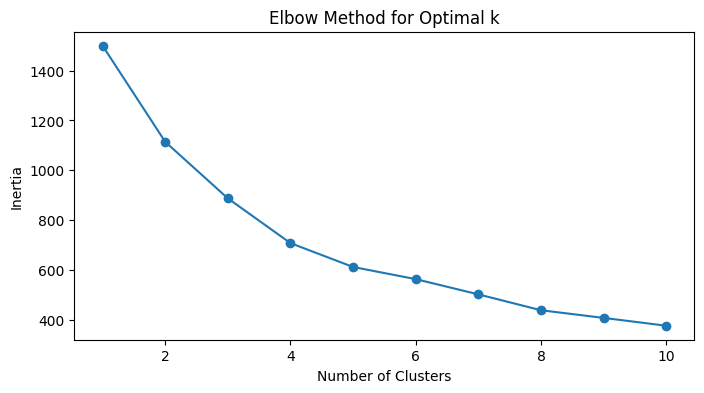

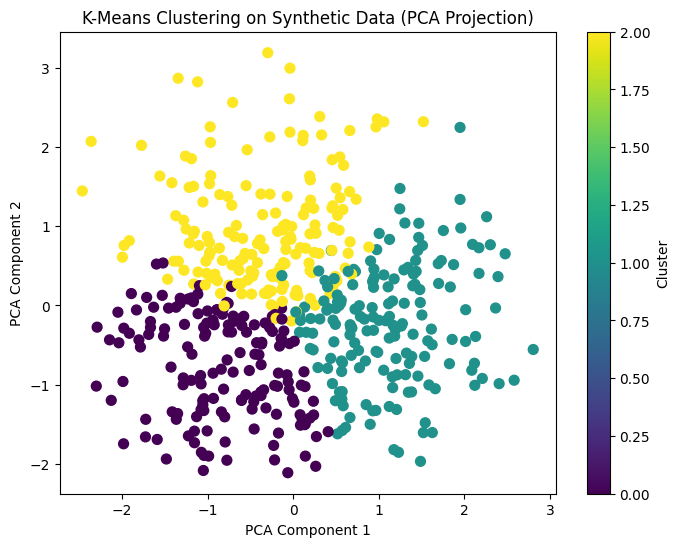


K-Means Silhouette Score: 0.24042843874543468


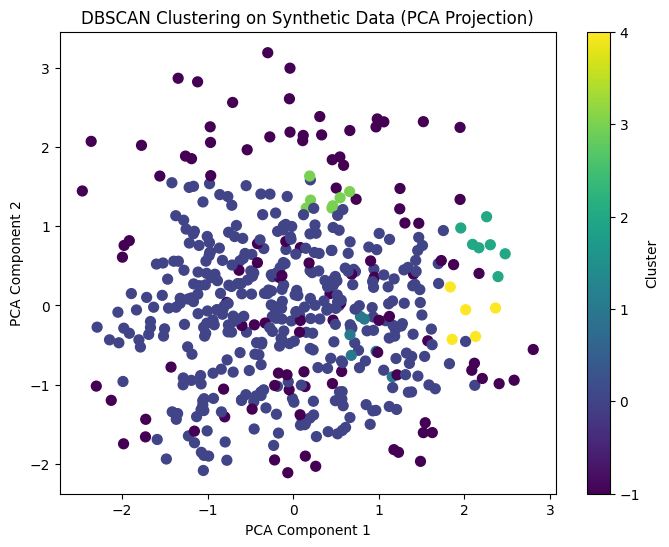


DBSCAN Silhouette Score (excluding noise): -0.0007137817604978569


In [5]:

# ------------------------------------------------
# 3. Clustering on the Synthetic Data
# ------------------------------------------------
# For clustering, we will use the numeric features: Age, Annual Income, and Spending Score.
# (Categorical data like Genre can be encoded if needed, but here we focus on the numeric aspects.)
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df_synthetic[features]

# Scale the features since clustering algorithms are distance based.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction using PCA (2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("\nExplained Variance Ratio (PCA):", pca.explained_variance_ratio_)

# -----------------------------
# 3a. K-Means Clustering
# -----------------------------
# K-Means is computationally efficient and works well for spherical clusters.
# Use the elbow method to estimate an optimal number of clusters.
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(X_scaled)
    inertia.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Assume based on the elbow plot that k=3 is optimal.
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
df_synthetic['KMeans_Cluster'] = kmeans_labels

# Visualize K-Means clusters on the PCA projection.
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title("K-Means Clustering on Synthetic Data (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

silhouette_avg_kmeans = silhouette_score(X_scaled, kmeans_labels)
print("\nK-Means Silhouette Score:", silhouette_avg_kmeans)

# -----------------------------
# 3b. DBSCAN Clustering
# -----------------------------
# DBSCAN is a density-based clustering algorithm that can identify clusters of arbitrary shape and detect noise.
# It does not require specifying the number of clusters, but it is sensitive to the eps and min_samples parameters.
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
df_synthetic['DBSCAN_Cluster'] = dbscan_labels

# Visualize DBSCAN clusters on the PCA projection.
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title("DBSCAN Clustering on Synthetic Data (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Compute silhouette score for DBSCAN (excluding noise points labeled as -1)
if len(set(dbscan_labels)) > 1:
    if -1 in dbscan_labels:
        mask = dbscan_labels != -1
        if np.sum(mask) > 1:
            silhouette_avg_dbscan = silhouette_score(X_scaled[mask], dbscan_labels[mask])
            print("\nDBSCAN Silhouette Score (excluding noise):", silhouette_avg_dbscan)
        else:
            print("\nNot enough clusters (excluding noise) for DBSCAN silhouette score.")
    else:
        silhouette_avg_dbscan = silhouette_score(X_scaled, dbscan_labels)
        print("\nDBSCAN Silhouette Score:", silhouette_avg_dbscan)
else:
    print("\nDBSCAN found only one cluster or no clusters.")


In [6]:

# ---------------------------------------------------
# 4. Interpreting the Clusters & Business Insights
# ---------------------------------------------------
# Group the synthetic data by K-Means cluster labels to derive segment profiles.
cluster_summary = df_synthetic.groupby('KMeans_Cluster')[features].mean()
print("\n=== K-Means Cluster Summary ===")
print(cluster_summary)

# Example Insights:
# - A cluster with a high average Spending Score might represent premium or loyal customers, ideal for exclusive offers.
# - Clusters characterized by lower spending but moderate income may be targeted with promotions or discounts.
# - Demographic attributes (like Age) further help in tailoring marketing messages.
#
# This process demonstrates how synthetic data generation can complement public datasets,
# allowing for robust testing of clustering techniques and marketing strategies.



=== K-Means Cluster Summary ===
                      Age  Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                                       
0               33.533054           44.869189               28.134252
1               52.958300           51.813094               65.331860
2               31.924978           83.815831               57.267661


In [9]:
df_synthetic.to_csv('synthetic_customer_data.csv', index=False)
